In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'LazyGraphDataSet'#'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [ ]:
############ stable 117 cases

# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

#lCsvColName     = ['Transaction ID', 'Block Time', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash', 'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used', 'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level']
#lCsvColNameFlag = [True,              True,         True,               True,        True,          True,            True,     True,       True,            True,            True,           True,        True,        True,       True,            True,         True,          False,   False]  #<! Flags if a column is a must to have
lCsvColName = [
'Transaction ID',
'Transaction Time',
'Block Time',	
'Sender ID',	
'Receiver ID',	
'Receiver Type',	
'Amount',	
'Currency',	
'Currency Hash',	
'Currency Type',	
'Amount [USD]',	
'Gas Price',	
'Gas Limit',	
'Gas Used',	
'Gas Predicted',	
'Balance In',	
'Balance Out',	
'Label',	
'Risk Level',	
'From Block Time',
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out',	
'transactions_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_total_transfers_USD_amount_in',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out',	
'transfers_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transactions_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transactions_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_transfers_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_transfers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transfers_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transfers_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'total_transactions_count_between_sender_and_receiver_before_block_time',	
'total_transactions_unique_days_count_between_sender_and_receiver_before_block_time',	
'total_transfers_count_between_sender_and_receiver_before_block_time',	
'total_transfers_unique_days_count_between_sender_and_receiver_before_block_time',	
'transfers_first_transfer_date_between_senderID_receiverID_before_block_time',	
'transfers_days_count_between_senderID_and_receiverID_from_first_transfer_date_to_current_transaction_date',	
'transactions_first_transaction_date_between_senderID_receiverID_before_block_time',	
'transactions_days_count_between_senderID_and_receiverID_from_first_transaction_date_to_current_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transactions_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_smart_contract_created',	
'transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation',	
'transfers_sent_or_received_unique_currency_count',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count.1',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count.1',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_date',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_sent_transactions_count',	
'transfers_anonymous_activity_from_mixerID_as_sender_to_receiverID_as_receiver_before_block_time',	
'transfers_anonymous_activity_from_receiverID_as_sender_to_mixerID_as_receiver_before_block_time',	
'transfers_mixerID_and_receiverID_before_block_time_first_activity_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount_less_equal_to_one',	
'transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount',	
'transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count',	
'transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date']	
lCsvColNameFlag = [
True,
False,
True,	
True,	
True,	
True,	
True,	
True,	
False,#'Currency Hash',	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True
]



# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
#dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
dfData, dAssetFile =  LoadCsvFilesDf(lCsvFile, baseFoldePath = '', lColName = lCsvColName, lColFlag =  lCsvColNameFlag ,  addFileNameCol = True )

numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

In [6]:
ttt = pd.read_csv('TemplateLazyGraph.csv')
columns_list = list(ttt.columns)

In [7]:
############ new format

# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

#lCsvColName     = ['Transaction ID', 'Block Time', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash', 'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used', 'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level']
#lCsvColNameFlag = [True,              True,         True,               True,        True,          True,            True,     True,       True,            True,            True,           True,        True,        True,       True,            True,         True,          False,   False]  #<! Flags if a column is a must to have
lCsvColName = columns_list


lCsvColNameFlag = [
True,
False,
True,	
True,	
True,	
True,	
True,	
True,	
False,#'Currency Hash',	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True
]



# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
#dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
dfData, dAssetFile =  LoadCsvFilesDf(lCsvFile, baseFoldePath = '', lColName = lCsvColName, lColFlag =  lCsvColNameFlag ,  addFileNameCol = True )

numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 161
The number of rows (Samples): 251934, The number of columns: 84, number of unique sender id's: (161,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'From Block Time',
       'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',
       'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transactions_count',
       'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',
       'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',
       'transactions_senderID_as_receiver_and_receiverID_as_sender_before_bloc

In [8]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [9]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [10]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,...,transactions_days_count_between_senderID_and_receiverID_from_first_transaction_date_to_current_transaction_date,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date,total_transfers_unique_days_count_between_sender_and_receiver_before_block_time,total_transactions_unique_days_count_between_sender_and_receiver_before_block_time,transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count,transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count,transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash,File Name
134768,0xf8e45e7a318827cd54a415005b30fc67dc4c62e0bb42...,NaN,2016-08-03 10:46:16+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,17016,0.0,0.0,0,0,1,1,NaN,NaN,FakeHack137001.csv
134767,0x056b34ec266003515e00f5c4dba9e07be9acf52a2e39...,NaN,2016-08-03 11:03:28+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,0,0.0,11088.0,2,1,1,1,NaN,NaN,FakeHack137001.csv
134766,0x25f0d4e11d6eb9929b9ddc85a6a2485b93337d65640e...,NaN,2016-08-03 11:37:25+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,5.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,0,0.0,11088.0,2,1,1,1,NaN,NaN,FakeHack137001.csv
134765,0x6008875514e32a1fc5152aac6deed0482ff5527aab3d...,NaN,2016-08-03 11:48:55+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,27.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,0,0.0,11088.0,2,1,1,1,NaN,NaN,FakeHack137001.csv
134764,0xa7f48ef0dac09e9e4174467c2b0e464a9b89707a2eec...,NaN,2016-08-03 12:21:39+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,5.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,0,0.0,11088.0,2,1,1,1,NaN,NaN,FakeHack137001.csv
171619,0x82ca4e875d300d61552b2546c2f51bb630cab4eb35ca...,NaN,2017-02-23 11:05:43+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0x86ed2df3159171dd3fc8361ae0e7c59f46cf0ea7,Wallet,0.01,ETH,0x0000000000000000000000000000000000000000,NaN,...,0,0.0,1.0,0,1,1,0,NaN,NaN,Multisig002.csv
171618,0x4ae416a730584c4d529d9bbaa08d193d86abff3b0f5e...,NaN,2017-02-28 12:01:26+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0xec466962b6d3e072f11ec455cc547178116290c8,Wallet,0.01,ETH,0x0000000000000000000000000000000000000000,NaN,...,17225,0.0,0.0,0,0,1,2,NaN,NaN,Multisig002.csv
134763,0x73b037de4db4029320e5a37b3e1ba5656ba158de21df...,NaN,2017-03-01 17:30:35+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0x6012ad30aa2c75976ee74f704c991c682ef62200,NaN,0.32,ETH,0x0000000000000000000000000000000000000000,NaN,...,17226,0.0,0.0,0,0,0,0,NaN,NaN,FakeHack137001.csv
134762,0x9a6712f22c005342c704ec2a0b8ec6cf2398c8434fe4...,NaN,2017-03-13 11:52:21+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0x006c3b72c45f680af995dd9b8777bc21eddcc779,NaN,0.20,ETH,0x0000000000000000000000000000000000000000,NaN,...,17238,0.0,0.0,0,0,0,0,NaN,NaN,FakeHack137001.csv
134761,0x75272367770177cf7e2b519524357565efecf2f2fcbd...,NaN,2017-03-13 11:55:47+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0x006c3b72c45f680af995dd9b8777bc21eddcc779,NaN,10.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,0,0.0,0.0,1,1,1,0,NaN,NaN,FakeHack137001.csv


# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [11]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,...,transactions_days_count_between_senderID_and_receiverID_from_first_transaction_date_to_current_transaction_date,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date,total_transfers_unique_days_count_between_sender_and_receiver_before_block_time,total_transactions_unique_days_count_between_sender_and_receiver_before_block_time,transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count,transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count,transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash,File Name
134439,0x477df43e6e4b318c8ffed00899a4d7f019c074a89882...,NaN,2017-06-11 12:49:35+00:00,0x1fb15d830ec3cecc9ceb52caff30ad9cb7edb75a,0x0c9d1b3ca852c67bbeabeeb51e9482a845d56868,NaN,6.100000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,...,17328,0.0,0.0,0,0,1,0,NaN,NaN,FAKEFundYourselfNow001.csv
134721,0x5aa40ba7c64177844bf740d6b5e77f6b39f546ce3314...,NaN,2017-06-11 13:08:20+00:00,0x5503ff6d5f128f482c9a01d4a7911e87be66fbf4,0x0c9d1b3ca852c67bbeabeeb51e9482a845d56868,NaN,2.000000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,...,17328,0.0,0.0,0,0,1,0,NaN,NaN,FAKEFundYourselfNow003.csv
134712,0x3acef6e3abf653b478be9774df4cca24109e9068d41f...,NaN,2017-06-11 17:30:19+00:00,0x27b206e22560a0d3c3b9122b102e85f178f5baa0,0x0c9d1b3ca852c67bbeabeeb51e9482a845d56868,NaN,2.890000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,...,17328,0.0,0.0,0,0,1,0,NaN,NaN,FAKEFundYourselfNow002.csv
171611,0x0e0d16475d2ac6a4802437a35a21776e5c9b681a77fe...,NaN,2017-07-18 22:33:23+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,2.679300e+04,ETH,0x0000000000000000000000000000000000000000,NaN,...,0,0.0,1.0,0,1,1,0,NaN,NaN,Multisig002.csv
171583,0x97f7662322d56e1c54bd1bab39bccf98bc736fcb9c7e...,NaN,2017-07-19 12:14:18+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,4.405500e+04,ETH,0x0000000000000000000000000000000000000000,NaN,...,0,3.0,4.0,0,1,1,1,NaN,NaN,Multisig001.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251921,0x948fb49fd7783e78bc8577e627b2724cdff3afd7c545...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,1.952864e+03,BADGER,0x3472a5a71965499acd81997a54bba8d852c6e53d,erc20,...,19255,0.0,0.0,1,0,77,70,NaN,NaN,Wintermute001.csv
251917,0x667559ba29645a6115c81ebcd09fddc571c6b97f479d...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,3.955927e+04,ENJ,0xf629cbd94d3791c9250152bd8dfbdf380e2a3b9c,erc20,...,19255,0.0,0.0,1,0,77,70,NaN,NaN,Wintermute001.csv
251916,0x5caa93f7398277f2aef8d30495150a8a8370f01a1785...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,1.425870e+04,API3,0x0b38210ea11411557c13457d4da7dc6ea731b88a,erc20,...,19255,0.0,0.0,1,0,77,70,NaN,NaN,Wintermute001.csv
251915,0x3fa1955e9ae94a41538ed1e606ff72cb9061fe595b07...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,9.080955e+10,ELON,0x761d38e5ddf6ccf6cf7c55759d5210750b5d60f3,erc20,...,19255,0.0,0.0,1,0,77,70,NaN,NaN,Wintermute001.csv


In [12]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    250029
1      1905
Name: Label, dtype: int64

In [13]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

161

In [14]:
dfData['Label'].value_counts()

0    250029
1      1905
Name: Label, dtype: int64

In [15]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251934 entries, 134768 to 207120
Data columns (total 84 columns):
 #   Column                                                                                                             Non-Null Count   Dtype              
---  ------                                                                                                             --------------   -----              
 0   Transaction ID                                                                                                     251934 non-null  object             
 1   Transaction Time                                                                                                   0 non-null       float64            
 2   Block Time                                                                                                         251934 non-null  datetime64[ns, UTC]
 3   Sender ID                                                                                     

In [16]:
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,...,total_transactions_count_between_sender_and_receiver_before_block_time,total_transfers_count_between_sender_and_receiver_before_block_time,transfers_days_count_between_senderID_and_receiverID_from_first_transfer_date_to_current_transaction_date,transactions_days_count_between_senderID_and_receiverID_from_first_transaction_date_to_current_transaction_date,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date,total_transfers_unique_days_count_between_sender_and_receiver_before_block_time,total_transactions_unique_days_count_between_sender_and_receiver_before_block_time,transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count,transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count
count,0.0,2.519340e+05,2.353750e+05,2.519340e+05,2.519340e+05,2.519340e+05,0.0,0.0,0.0,251934.000000,...,251934.000000,251934.000000,251934.000000,251934.000000,251934.000000,2.519340e+05,251934.000000,251934.000000,251934.000000,251934.000000
mean,NaN,4.604381e+71,2.641406e+05,8.305365e-08,1.099030e+06,8.293967e+05,NaN,NaN,NaN,0.007562,...,46.126561,714.644748,6076.786047,11658.139862,190.587491,6.355412e+03,27.780962,11.618868,70.707483,69.346579
std,NaN,2.311078e+74,4.106330e+06,1.365204e-07,2.719938e+06,2.376962e+06,NaN,NaN,NaN,0.086628,...,236.624578,3666.673260,8608.311726,8957.936500,7040.189115,1.548677e+05,78.032301,49.323573,246.319368,255.027462
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+04,1.920000e+04,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,NaN,3.000000e-01,3.393168e+01,2.700000e-08,6.000000e+04,3.019325e+04,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,10.000000,97.000000,0.000000,0.000000e+00,0.000000,0.000000,2.000000,1.000000
50%,NaN,1.297686e+01,6.833471e+02,4.200000e-08,1.550760e+05,9.557800e+04,NaN,NaN,NaN,0.000000,...,0.000000,3.000000,99.000000,18058.000000,0.000000,0.000000e+00,2.000000,0.000000,8.000000,4.000000
75%,NaN,4.083509e+03,4.829521e+03,9.289050e-08,5.385560e+05,2.057850e+05,NaN,NaN,NaN,0.000000,...,2.000000,62.000000,18051.000000,18760.000000,0.000000,4.000000e+00,12.000000,2.000000,36.000000,23.000000
max,NaN,1.160000e+77,6.141830e+08,1.440000e-05,2.805929e+07,2.577378e+07,NaN,NaN,NaN,1.000000,...,8809.000000,30969.000000,19258.000000,19258.000000,995533.000000,8.640369e+06,681.000000,533.000000,8494.000000,5399.000000


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [17]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 25267


In [18]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [19]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [20]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [21]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 226667, The number of columns: 84


# Meet the Data

Basic infomration about the data.

In [22]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226667 entries, 134768 to 207120
Data columns (total 84 columns):
 #   Column                                                                                                             Non-Null Count   Dtype              
---  ------                                                                                                             --------------   -----              
 0   Transaction ID                                                                                                     226667 non-null  object             
 1   Transaction Time                                                                                                   0 non-null       float64            
 2   Block Time                                                                                                         226667 non-null  datetime64[ns, UTC]
 3   Sender ID                                                                                     

In [23]:
# Numeric Data Description
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,...,total_transactions_count_between_sender_and_receiver_before_block_time,total_transfers_count_between_sender_and_receiver_before_block_time,transfers_days_count_between_senderID_and_receiverID_from_first_transfer_date_to_current_transaction_date,transactions_days_count_between_senderID_and_receiverID_from_first_transaction_date_to_current_transaction_date,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date,total_transfers_unique_days_count_between_sender_and_receiver_before_block_time,total_transactions_unique_days_count_between_sender_and_receiver_before_block_time,transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count,transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count
count,0.0,2.266670e+05,2.266670e+05,2.266670e+05,2.266670e+05,2.266670e+05,0.0,0.0,0.0,226667.000000,...,226667.000000,226667.000000,226667.000000,226667.000000,226667.000000,2.266670e+05,226667.000000,226667.000000,226667.000000,226667.000000
mean,NaN,4.274942e+10,2.742882e+05,8.269865e-08,8.972654e+05,6.442747e+05,NaN,NaN,NaN,0.008140,...,50.706530,788.335775,5817.439310,11733.615476,203.971999,6.982016e+03,29.978449,12.628336,72.851774,68.848672
std,NaN,3.805015e+12,4.184132e+06,1.355368e-07,2.398062e+06,2.071185e+06,NaN,NaN,NaN,0.089853,...,248.525075,3857.521524,8510.644688,8949.633467,7418.681096,1.631626e+05,81.354342,51.802440,252.371247,244.989963
min,NaN,1.000000e-18,3.580000e-34,0.000000e+00,2.100000e+04,1.920000e+04,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,NaN,3.843414e-01,6.332196e+01,2.700000e-08,5.287500e+04,2.100000e+04,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,12.000000,110.000000,0.000000,0.000000e+00,0.000000,0.000000,2.000000,1.000000
50%,NaN,1.048500e+01,7.967722e+02,4.500000e-08,1.550900e+05,9.455800e+04,NaN,NaN,NaN,0.000000,...,0.000000,4.000000,94.000000,18059.000000,0.000000,0.000000e+00,2.000000,0.000000,8.000000,5.000000
75%,NaN,2.991003e+03,5.154590e+03,9.333168e-08,5.000000e+05,1.989980e+05,NaN,NaN,NaN,0.000000,...,2.000000,74.000000,18049.000000,18772.000000,0.000000,5.000000e+00,14.000000,2.000000,39.000000,25.000000
max,NaN,1.210000e+15,6.141830e+08,1.440000e-05,2.805929e+07,2.577378e+07,NaN,NaN,NaN,1.000000,...,8809.000000,30969.000000,19258.000000,19258.000000,995533.000000,8.640369e+06,681.000000,533.000000,8494.000000,5399.000000


In [ ]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [ ]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [ ]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [ ]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [ ]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [ ]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [ ]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [ ]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [ ]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [ ]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [ ]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [ ]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


In [ ]:
dfData.columns.shape

In [ ]:
'''
Block time minus from "U" to "AB" columns
U-V
W-X
Y-Z
AA-AB
BC-BE
Intervals
transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in divided by AK
transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in divided by AL
transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out divided by AI
transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out divided by AJ
AE divided by AC
AH divided by AF
AG divided by AQ
AG divided by AR
Count ratio of AU and AW
Count ratio of AI and AK
CD/CX
CB/BW

'''
#transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date	transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date	transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date	transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date	transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date	transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date	transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date	transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date


In [24]:
date_cols = [
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date',
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date',
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date',
'transfers_first_transfer_date_between_senderID_receiverID_before_block_time',
'transactions_first_transaction_date_between_senderID_receiverID_before_block_time'
]

for col in date_cols:
    dfData[col] = pd.to_datetime(dfData[col], infer_datetime_format = 'True') #<! Stable time format

In [25]:
new_cols = []
for col in date_cols:
    dfData[col+'_diff'] = (dfData['Block Time'] - dfData[col]).astype('timedelta64[h]').astype('float')
    new_cols.append(col+'_diff')

#dfData['d1'] = (dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date'] - dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date']).astype('timedelta64[h]').astype('int')
dfData['d2'] = (dfData['transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date'] - dfData['transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date']).astype('timedelta64[h]').astype('int')
dfData['d3'] = (dfData['transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date']	- dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date']).astype('timedelta64[h]').astype('int')
dfData['d4'] = (dfData['transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date'] - dfData['transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date']).astype('timedelta64[h]').astype('int')
dfData['d5'] = (dfData['transfers_first_transfer_date_between_senderID_receiverID_before_block_time'] - dfData['transactions_first_transaction_date_between_senderID_receiverID_before_block_time']).astype('timedelta64[h]').astype('int')

dfData['r1'] = dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in']/dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count']
dfData['r2'] = dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in']/dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count']
dfData['r3'] = dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out']/dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count']
dfData['r4'] = dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out']/dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count']

dfData['r5'] = dfData['transactions_receiverID_as_receiver_from_any_sender_first_received_amount']/dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in']
dfData['r6'] = dfData['transfers_receiverID_as_receiver_from_any_sender_first_received_amount']/dfData['transfers_receiverID_as_receiver_from_any_sender_before_block_time_total_transfers_USD_amount_in']
dfData['r7'] = dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out']/dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_transfers_count']
dfData['r8'] = dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out']/dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count']
dfData['r9'] = dfData['transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transfers_count']/dfData['transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transfers_count']
dfData['r10'] = dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count']/dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count']
dfData['r11'] = dfData['transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount']/dfData['transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count']


new_cols.extend(['d2','d3','d4','d5','r1','r2','r3','r4','r5','r6','r7','r8','r9','r10','r11'])

#new_cols.extend(['d1','d2','d3','d4','d5','r1','r2','r3','r4','r5','r6','r7','r8','r9','r10','r11'])



In [ ]:
#transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in/transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count divided by AK(ac/ak)
#transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in/transactions_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count divided by AL
#transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out/transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count divided by AI
#transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out/transactions_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count divided by AJ
#AE divided by AC = transactions_receiverID_as_receiver_from_any_sender_first_received_amount/transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in
#AH divided by AF = transfers_receiverID_as_receiver_from_any_sender_first_received_amount/transfers_receiverID_as_receiver_from_any_sender_before_block_time_total_transfers_USD_amount_in
#AG divided by AQ = transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out/transfers_receiverID_as_sender_to_any_receiver_before_block_time_transfers_count
#AG divided by AR = transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out/transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count
#Count ratio of AU and AW = transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transfers_count/transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transfers_count
#Count ratio of AI and AK = transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count/transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count
#CD/CX = transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount
#CB/BW = transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount/transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count
#U-V = transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date	transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date
#W-X = transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date	transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date
#Y-Z = transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date	transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date
#AA-AB = transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date	transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date
#BC-BE transfers_first_transfer_date_between_senderID_receiverID_before_block_time	transactions_first_transaction_date_between_senderID_receiverID_before_block_time


In [26]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 


In [27]:
for col in ['Block Time', 
            'From Block Time', 
            'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date', 
            'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date', 
            'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date', 
            'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date', 
            'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date', 
            'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date', 
            'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date', 
            'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date', 
            'transfers_first_transfer_date_between_senderID_receiverID_before_block_time', 
            'transactions_first_transaction_date_between_senderID_receiverID_before_block_time',
             'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_date', 
             'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_date', 
             'transfers_mixerID_and_receiverID_before_block_time_first_activity_date']:



    print(col)         
    dfData_[col] =  pd.to_datetime(dfData_[col]).dt.tz_localize(None).astype(np.int64)
    #transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation

Block Time
From Block Time
transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date
transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date
transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date
transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date
transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date
transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date
transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date
transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date
transfers_first_transfer_date_between_senderID_receiverID_before_block_time
transactions_first_transaction_date_between_senderID_receiverID_before_block_time
transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_ti

## Features Visualization

### K-fold training, using categorical variables (EXPERIMENT)

In [31]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']
#lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]

lNumericalFeatures = [#lCsvColName = [
'Block Time',		
'Amount',	
'Amount [USD]',	
'Gas Price',	
'Gas Limit',	
'Gas Used',	
'Gas Predicted',	
'Balance In',	
'Balance Out',		
'Risk Level',	
'From Block Time',
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out',	
'transactions_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_total_transfers_USD_amount_in',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out',	
'transfers_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transactions_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transactions_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_transfers_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_transfers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transfers_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transfers_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'total_transactions_count_between_sender_and_receiver_before_block_time',	
'total_transactions_unique_days_count_between_sender_and_receiver_before_block_time',	
'total_transfers_count_between_sender_and_receiver_before_block_time',	
'total_transfers_unique_days_count_between_sender_and_receiver_before_block_time',	
'transfers_first_transfer_date_between_senderID_receiverID_before_block_time',	
'transfers_days_count_between_senderID_and_receiverID_from_first_transfer_date_to_current_transaction_date',	
'transactions_first_transaction_date_between_senderID_receiverID_before_block_time',	
'transactions_days_count_between_senderID_and_receiverID_from_first_transaction_date_to_current_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transactions_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_smart_contract_created',	
'transfers_sent_or_received_unique_currency_count',	
#'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count.1',	
#'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count.1',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_date',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_sent_transactions_count',	
'transfers_anonymous_activity_from_mixerID_as_sender_to_receiverID_as_receiver_before_block_time',	
'transfers_anonymous_activity_from_receiverID_as_sender_to_mixerID_as_receiver_before_block_time',	
'transfers_mixerID_and_receiverID_before_block_time_first_activity_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount_less_equal_to_one',	
'transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount',	
'transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count',	
'transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date']
#lNumericalFeatures.extend(new_cols)

lTotalFeatures = lNumericalFeatures + lCatFeatures

In [29]:
lNumericalFeatures + new_cols

['Block Time',
 'Amount',
 'Amount [USD]',
 'Gas Price',
 'Gas Limit',
 'Gas Used',
 'Gas Predicted',
 'Balance In',
 'Balance Out',
 'Risk Level',
 'From Block Time',
 'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',
 'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',
 'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',
 'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',
 'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date',
 'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date',
 'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date',
 'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date',
 'transactions_receiverID_as_receiver_from_any_sender_be

In [32]:
dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
#dfData_[dfData_.columns[~dfData_.columns.isin(new_cols)]].fillna(0, inplace = True)
dfX_ = dfData_[lTotalFeatures + new_cols].copy()#dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures + new_cols] = hStdScaler.fit_transform(dfX_[lNumericalFeatures + new_cols])


In [33]:
dfdata_ = dfData_[dfData_.columns[~dfData_.columns.isin(['transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
                                               'transfers_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
                                               'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash', 
                                               'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash',
                                               'Currency', 
                                               'Currency Type', 
                                               'Receiver Type'])]]

In [34]:
for col in ['Block Time', 
            'From Block Time', 
            'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date', 
            'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date', 
            'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date', 
            'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date', 
            'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date', 
            'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date', 
            'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date', 
            'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date', 
            'transfers_first_transfer_date_between_senderID_receiverID_before_block_time', 
            'transactions_first_transaction_date_between_senderID_receiverID_before_block_time',
            #'transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
            #'transfers_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
            #'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash',
             #'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash', 
             'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_date', 
             'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_date', 
             'transfers_mixerID_and_receiverID_before_block_time_first_activity_date']:
    print(col)         
    dfData_[col] =  pd.to_datetime(dfData_[col]).dt.tz_localize(None).astype(np.int64)
    #transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation

Block Time
From Block Time
transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date
transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date
transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date
transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date
transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date
transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date
transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date
transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date
transfers_first_transfer_date_between_senderID_receiverID_before_block_time
transactions_first_transaction_date_between_senderID_receiverID_before_block_time
transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_ti

In [35]:
mX = dfX_[lTotalFeatures + new_cols]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


In [36]:
mX = mX[mX.columns[~mX.columns.isin(['transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
                                               'transfers_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
                                               'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash', 
                                               'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash',
                                               'Currency', 
                                               'Currency Type', 
                                               'Receiver Type'])]]
                                              

In [ ]:
#mX.replace([np.inf, -np.inf], np.nan, inplace = True)
#mX.fillna(0, inplace = True)
#hStdScaler = StandardScaler()
#mX[lNumericalFeatures] = hStdScaler.fit_transform(mX[lNumericalFeatures])


In [ ]:
mX.columns

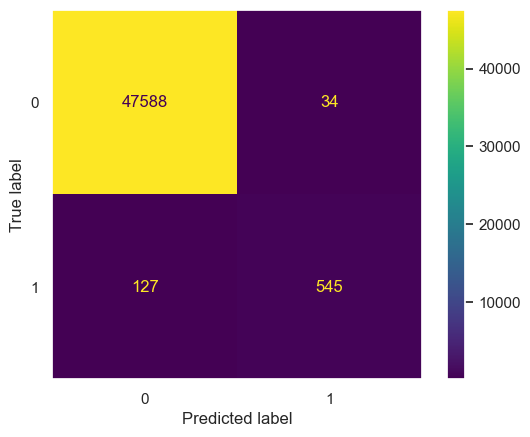

Accuracy         0.996666
F1               0.871303
Precision        0.941278
Recall           0.811012
ROC AUC Score    0.905149
dtype: float64


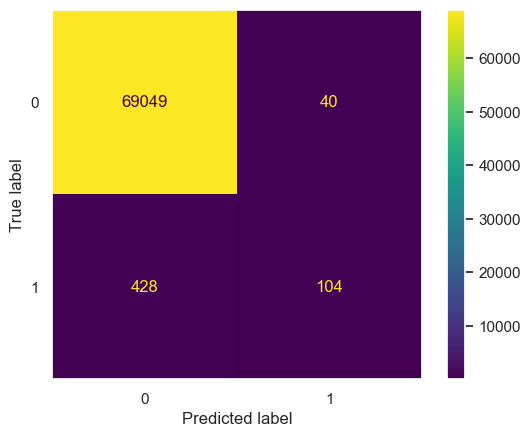

Accuracy         0.993278
F1               0.307692
Precision        0.722222
Recall           0.195489
ROC AUC Score    0.597455
dtype: float64


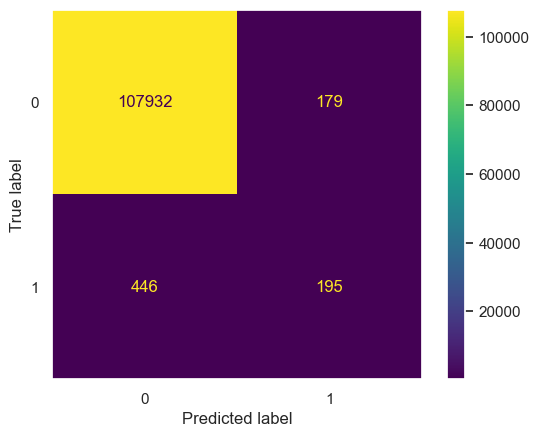

Accuracy         0.994253
F1               0.384236
Precision        0.521390
Recall           0.304212
ROC AUC Score    0.651278
dtype: float64


In [37]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData_['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=750, tree_method="hist", max_depth = 7,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [ ]:
models = []
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData_['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=750, tree_method="hist", max_depth = 7,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))
    models.append([vTrainIdx , vTestIdx , xgbModel])


Data - Dataset used for training and testing, 
       distribution, 
	   total number of cases, 
	   number of transactions and hacker transactions

Features - list of features used

Model- model version and type

Results - F1 score on the results, 
        which cases we had the best results and which cases we had worst results, 
		(cases = names of hack and the classification whether it is fishing, scam, smart contract exploit etc.) 
		include in this analysis the 3 kfold results.

Conclusions if any

In [ ]:
dfData_.iloc[models[-1][0]].shape , dfData_.iloc[models[-1][1]].shape 


In [ ]:
dftr = dfData_.iloc[models[-1][0]] 
dft = dfData_.iloc[models[-1][1]] 
#, dfData_.shape

In [ ]:
d1 = dfData_.iloc[models[0][0]]
d2 = dfData_.iloc[models[0][1]]

In [ ]:
d2[d2['Label'] == 0].shape , d2[d2['Label'] == 1].shape 
#dft = dfData_.iloc[models[-1][1]] 
#, dfData_.shape

In [ ]:
dfData_['Attack_Type'] =  dfData_.apply(lambda x: dat[x['File Name']] if x['File Name'] in dat else 'not found',axis=1)
#dfData_['File Name'].apply(lambda x: print(x))

In [ ]:
dfData_['Attack_Type'].iloc[models[0][1]].value_counts()

In [ ]:
dfData_.iloc[models[0][0]]['File Name'].unique().shape , dfData_.iloc[models[0][1]]['File Name'].unique().shape

In [ ]:
pd.DataFrame(dfData_['File Name'].unique()).to_csv('all_files_names.csv')
pd.DataFrame(dfData_.iloc[models[-1][0]]['File Name'].unique()).to_csv('trains_files_names.csv')
pd.DataFrame(dfData_.iloc[models[-1][1]]['File Name'].unique()).to_csv('test_files_names.csv')

In [ ]:
all_f = dfData_['File Name'].unique()
train_f = dfData_.iloc[models[-1][0]]['File Name'].unique()
test_f = dfData_.iloc[models[-1][1]]['File Name'].unique()

In [ ]:
import collections
collections.Counter([dat[i] for i in dfData_.iloc[models[0][1]]['File Name'].unique()])


In [ ]:
dfData_['Attack_Type'].iloc[models[-1][0]].value_counts().to_dict()

In [ ]:
#dfData_['File Name'].unique().shape
#dfData_.iloc[models[-1][0]]['File Name'].unique().shape
#dfData_.iloc[models[-1][1]]['File Name'].unique()

In [ ]:
#[dat[i] if i in dat else 'not found' for i in train_f]

In [ ]:
dd = pd.read_csv('hack_types.csv' , index_col=False)
dd = dd.reset_index(drop=True)
dd['Attack_Name'] = dd['Attack_Name'] + '.csv'	
	
dat = dd.set_index('Attack_Name').to_dict()['Attack_Type']

In [ ]:
mX.columns

In [ ]:
mXTrain, mXTest, vYTrain, vYTest = mX.iloc[models[-1][0]], mX.iloc[models[-1][1]], vY.iloc[models[-1][0]], vY.iloc[models[-1][1]]
mdl = models[-1][-1]
#mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
vYPred = mdl.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = mdl.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))

#models.append([vTrainIdx , vTestIdx , xgbModel])

In [ ]:
#dfData_['c1'] = None; dfData_['c2'] = None
dfData_['c1'].iloc[models[-1][1]] = vYTest ; dfData_['c2'].iloc[models[-1][1]] = vYPred

In [ ]:
dfData_[(dfData_['c1'] == 1) & (dfData_['c2'] == 0)][['Transaction ID' , 'File Name']].to_csv('12.csv')
#dfData_[(dfData_['c1'] == 1) & (dfData_['c2'] == 0)][['Transaction ID' ]]

In [ ]:
collections.Counter([dat[i] for i in dfData_.iloc[models[0][1]]['File Name'].unique()]).keys() , collections.Counter([dat[i] for i in dfData_.iloc[models[0][1]]['File Name'].unique()]).values()


In [ ]:
collections.Counter([dat[i] for i in dfData_.iloc[models[0][1]]['File Name'].unique()])

In [ ]:
 
data = collections.Counter([dat[i] for i in dfData_.iloc[models[0][1]]['File Name'].unique()]) 



def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format
plt.pie(data.values(), labels = data.keys(), autopct = autopct_format(data.values()))

In [ ]:
data = dfData_['Attack_Type'].iloc[models[0][1]].value_counts().to_dict()
 
 



def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format
plt.pie(data.values(), labels = data.keys(), autopct = autopct_format(data.values()))